In [1]:
!pip install opendatasets

In [2]:
import pandas as pd
import numpy as np
import opendatasets as od
import os
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import figure
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
url = "https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adeeljohn
Your Kaggle Key: ··········


100%|██████████| 269M/269M [00:02<00:00, 128MB/s]


In [4]:
directory = "./gender-classification-dataset"

In [5]:
os.listdir(directory)

['Training', 'Validation']

In [6]:
folder_path = "./gender-classification-dataset/Training"

In [7]:
file_list = os.listdir(folder_path)
file_list

['female', 'male']

In [8]:
for cls in file_list:
  print(cls, ':', len(os.listdir(folder_path  + "/" + cls)))

female : 23243
male : 23766


In [9]:
dataset = ImageFolder(folder_path, transform = tt.Compose([tt.Resize(255), tt.RandomCrop(224), tt.ToTensor()]))

In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 47009
    Root location: ./gender-classification-dataset/Training
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(224, 224), padding=None)
               ToTensor()
           )

In [11]:
dataset.classes

['female', 'male']

In [12]:
dataset.class_to_idx

{'female': 0, 'male': 1}

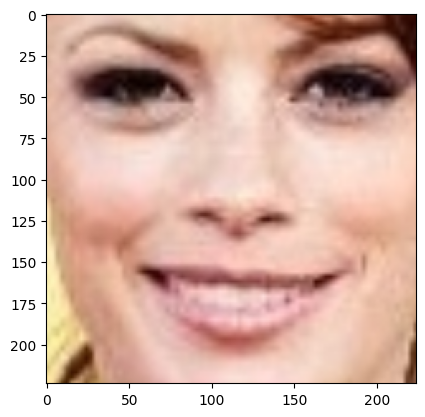

In [13]:
image, label = dataset[23]
plt.imshow(image.permute(1,2,0))

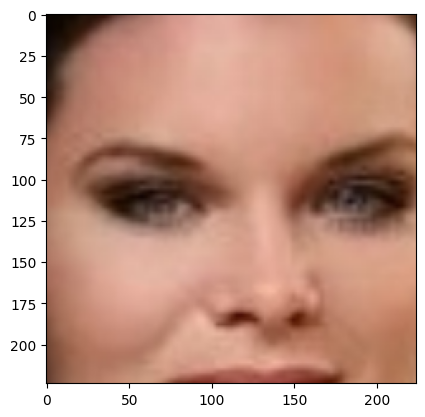

In [14]:
image, label = dataset[69]
plt.imshow(image.permute(1,2,0))

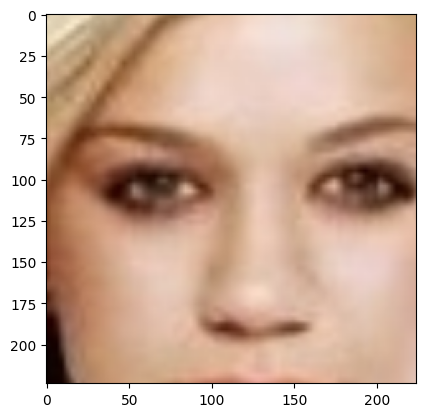

In [15]:
image, label = dataset[4039]
plt.imshow(image.permute(1,2,0))

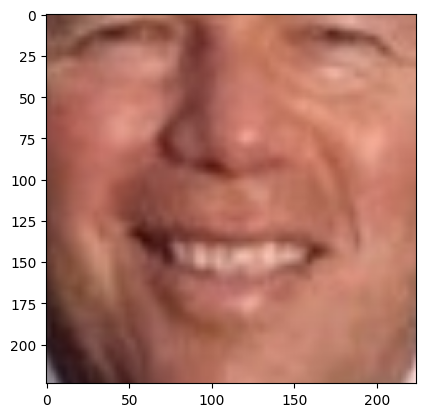

In [16]:
image, label = dataset[45000]
plt.imshow(image.permute(1,2,0))

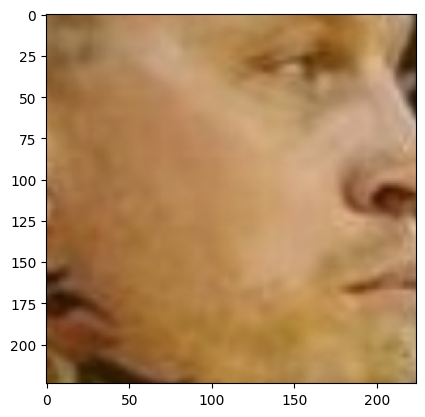

In [17]:
image, label = dataset[36547]
plt.imshow(image.permute(1,2,0))

In [18]:
size_per = 0.2
valid_size = int(len(dataset) * size_per)
train_size = len(dataset) - valid_size

In [19]:
print(train_size, valid_size)

37608 9401


In [20]:
train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
len(train_ds), len(valid_ds)

(37608, 9401)

In [21]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
def show_batch(dl):
  for image, _ in dl:
    px, ax = plt.subplots(figsize=(16,12))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(image, nrow=16).permute(1,2,0))
    torch.cuda.empty_cache
    break

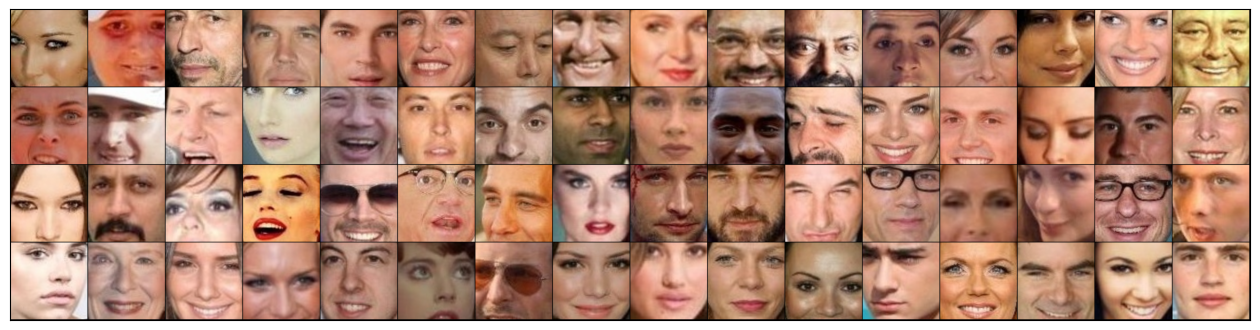

In [23]:
show_batch(train_dl)

In [24]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cpu')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [27]:
class MaleFemale(nn.Module):
    """ calculate the loss of batch of training dataloader"""
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        torch.cuda.empty_cache
        return loss
    """calculate the loss and accuracy of batch of validation dataloader"""
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        torch.cuda.empty_cache
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [28]:
class CNN(MaleFemale):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    """ Define the model's performance on validation set..."""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            torch.cuda.empty_cache
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        torch.cuda.empty_cache
    return history

In [30]:
model = to_device(CNN(len(dataset.classes)), device)
model

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6931896805763245, 'val_acc': 0.4928187131881714}]

In [32]:
%%time
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.6700, val_loss: 0.3180, val_acc: 0.8629
Epoch [1], train_loss: 0.2786, val_loss: 0.2433, val_acc: 0.9018
Epoch [2], train_loss: 0.2243, val_loss: 0.4395, val_acc: 0.8489
Epoch [3], train_loss: 0.2088, val_loss: 0.1734, val_acc: 0.9374
Epoch [4], train_loss: 0.1899, val_loss: 0.1938, val_acc: 0.9344
CPU times: user 7min 55s, sys: 8min 38s, total: 16min 33s
Wall time: 19min 16s


In [33]:
%%time
history += fit(1, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1385, val_loss: 0.1239, val_acc: 0.9559
CPU times: user 1min 35s, sys: 1min 43s, total: 3min 19s
Wall time: 3min 51s


In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

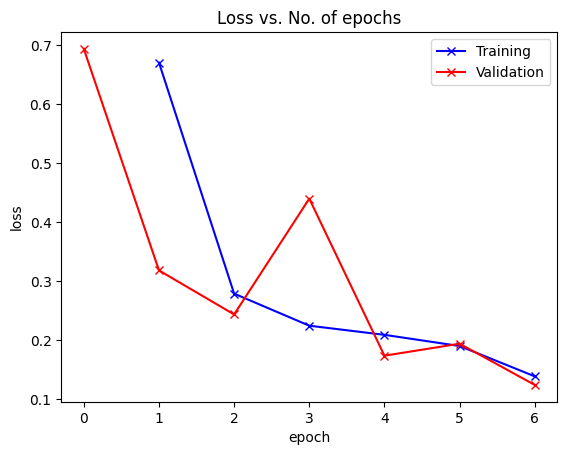

In [35]:
plot_losses(history)

In [36]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [37]:
def show_image_prediction(img, label):
  plt.imshow(img.permute(1, 2, 0))
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: male , Predicted: male


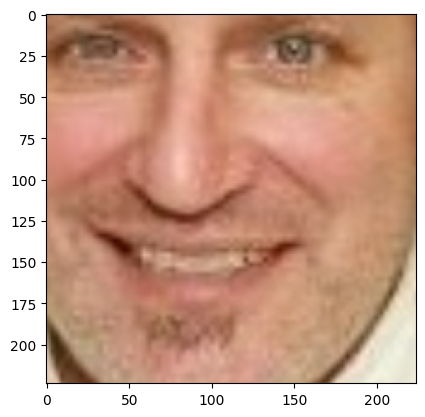

In [38]:
show_image_prediction(*valid_ds[154])

Label: female , Predicted: female


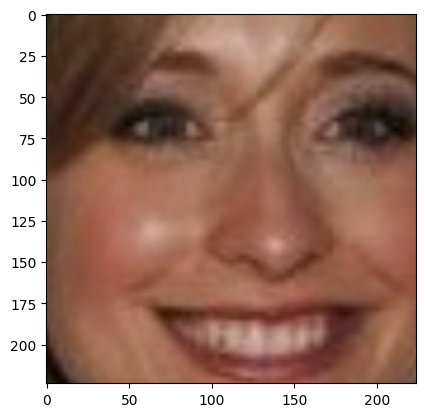

In [39]:
show_image_prediction(*valid_ds[2196])

Label: male , Predicted: male


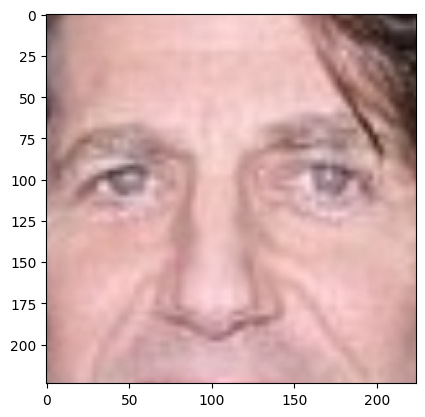

In [40]:
show_image_prediction(*valid_ds[5377])

Label: male , Predicted: male


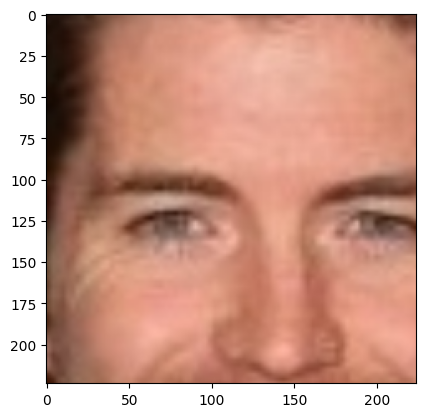

In [41]:
show_image_prediction(*valid_ds[2992])